In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. 환경 설정 및 데이터 준비

## 1.1 라이브러리 임포트

In [45]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Dropout,
    Conv1D, MaxPooling1D, LSTM, GRU, concatenate, Bidirectional, GlobalAveragePooling1D
)
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

## 1.2 데이터 로드 헬퍼 함수 정의

In [46]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [47]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

In [48]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [49]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/Colab Notebooks/machine-learning-programming/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/Colab Notebooks/machine-learning-programming/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

## 1.3 데이터 로드 및 검증 세트 분리

In [50]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)
X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [51]:
# 3D 데이터를 스케일링하기 위해 (samples, timesteps, features) -> (samples * timesteps, features) 2D로 변환
n_features = X_train.shape[2]
X_train_2d = X_train.reshape(-1, n_features)
X_val_2d = X_val.reshape(-1, n_features)
testX_2d = testX.reshape(-1, n_features)

In [52]:
# Train 데이터 기준으로 스케일러 피팅
scaler = StandardScaler()
X_train_scaled_2d = scaler.fit_transform(X_train_2d)
X_val_scaled_2d = scaler.transform(X_val_2d)
testX_scaled_2d = scaler.transform(testX_2d)

In [53]:
# 다시 3D (samples, timesteps, features) 형태로 복원
X_train_scaled = X_train_scaled_2d.reshape(X_train.shape)
X_val_scaled = X_val_scaled_2d.reshape(X_val.shape)
testX_scaled = testX_scaled_2d.reshape(testX.shape)

In [54]:
print("Scaling completed. Scaled Train Shape:", X_train_scaled.shape)

Scaling completed. Scaled Train Shape: (5881, 128, 9)


# 2. 모델 정의

## 2.1 모델 파라미터 설정

In [55]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [56]:
# 공통 학습 파라미터
EPOCHS = 100
BATCH_SIZE = 64

# 입력 형태 정의
input_shape = (n_timesteps, n_features)

## 2.2 LSTM 모델 정의

In [57]:
def build_lstm_model():
    reg = l2(1e-4) # L2 규제 인스턴스

    model = Sequential([
        Input(shape=input_shape, name="Input_LSTM"),

        Bidirectional(
            LSTM(100, return_sequences=True, kernel_regularizer=reg),
            name="Bi-LSTM_1"
        ),
        Dropout(0.3),

        Bidirectional(
            LSTM(100, return_sequences=True, kernel_regularizer=reg),
            name="Bi-LSTM_2"
        ),
        Dropout(0.3),

        GlobalAveragePooling1D(name="GAP"),

        # 분류기
        Dense(128, activation='relu', kernel_regularizer=reg),
        Dropout(0.5),
        Dense(n_outputs, activation='softmax', name="Output")
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# 3. 모델 빌드

In [58]:
model_lstm = build_lstm_model()

In [59]:
model_lstm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Bi-LSTM_1 (Bidirectional)       │ (None, 128, 200)       │        88,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128, 200)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bi-LSTM_2 (Bidirectional)       │ (None, 128, 200)       │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128, 200)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GAP (GlobalAveragePooling1D)    │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,302 (1.36 MB)

 Trainable params: 355,302 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

# 4. 모델 학습

In [60]:
# Callbacks 정의
# 15 Epochs 동안 val_loss가 개선되지 않으면 학습 중단 및 최적 가중치 복원
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
# 5 Epochs 동안 val_loss가 개선되지 않으면 학습률을 0.2배로 감소
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
callbacks = [early_stopping, reduce_lr]

In [61]:
history = model_lstm.fit(
    X_train_scaled, # 스케일링된 데이터 사용
    y_train_one_hot,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_scaled, y_val_one_hot), # 스케일링된 데이터 사용
    verbose=2,
    callbacks=callbacks # 콜백 적용
)

Epoch 1/100
92/92 - 7s - 77ms/step - accuracy: 0.8323 - loss: 0.5401 - val_accuracy: 0.9327 - val_loss: 0.2173 - learning_rate: 1.0000e-03
Epoch 2/100
92/92 - 3s - 28ms/step - accuracy: 0.9407 - loss: 0.2111 - val_accuracy: 0.9463 - val_loss: 0.1912 - learning_rate: 1.0000e-03
Epoch 3/100
92/92 - 3s - 28ms/step - accuracy: 0.9537 - loss: 0.1746 - val_accuracy: 0.9490 - val_loss: 0.1916 - learning_rate: 1.0000e-03
Epoch 4/100
92/92 - 3s - 28ms/step - accuracy: 0.9464 - loss: 0.1887 - val_accuracy: 0.9504 - val_loss: 0.1728 - learning_rate: 1.0000e-03
Epoch 5/100
92/92 - 3s - 30ms/step - accuracy: 0.9507 - loss: 0.1714 - val_accuracy: 0.9511 - val_loss: 0.1582 - learning_rate: 1.0000e-03
Epoch 6/100
92/92 - 3s - 32ms/step - accuracy: 0.9563 - loss: 0.1570 - val_accuracy: 0.9545 - val_loss: 0.1587 - learning_rate: 1.0000e-03
Epoch 7/100
92/92 - 3s - 28ms/step - accuracy: 0.9594 - loss: 0.1450 - val_accuracy: 0.9456 - val_loss: 0.1503 - learning_rate: 1.0000e-03
Epoch 8/100
92/92 - 3s - 28

# 4. 결과 분석 및 평가

## 4.1 학습 과정 시각화 (Loss & Accuracy)

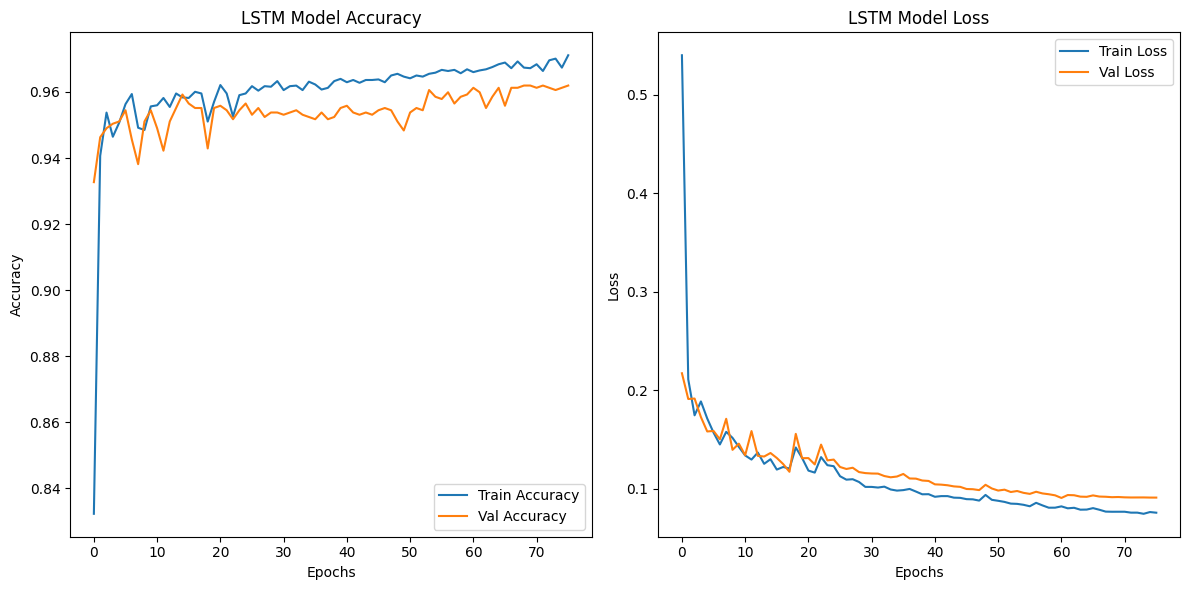

In [62]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

## 4.2 테스트 세트 평가 (Confusion Matrix)

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Accuracy: 0.9311

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       496
           1       0.97      0.97      0.97       471
           2       0.92      0.99      0.95       420
           3       0.84      0.84      0.84       491
           4       0.87      0.85      0.86       532
           5       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



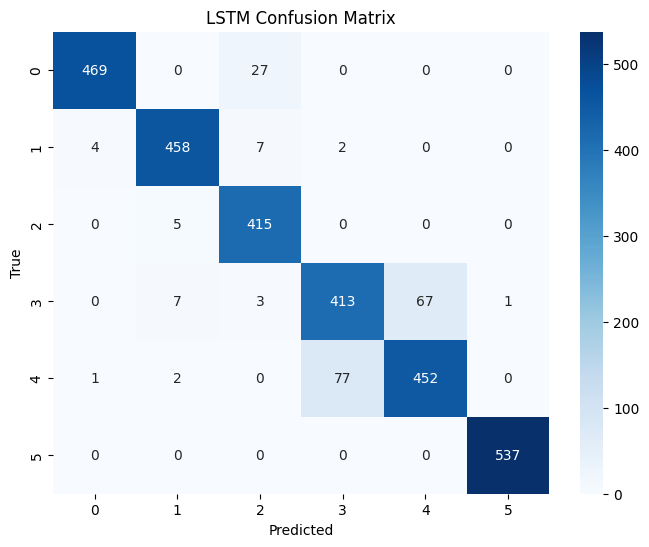

In [63]:
pred_probs = model_lstm.predict(testX_scaled)
pred_classes = np.argmax(pred_probs, axis=-1)

print(f"Accuracy: {accuracy_score(testy, pred_classes):.4f}")
print("\nClassification Report:")
print(classification_report(testy, pred_classes))

cm = confusion_matrix(testy, pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()